In [1]:
import os
from pathlib import Path
import sys

import numpy as np
import matplotlib.pyplot as plt
import xarray
import rioxarray
import rasterio

## Stitching experimentation

In [2]:
preds_dir = Path("../data/predictions/nigeria-cropharvest-full-country-2020/nc_files")
vrts_dir = Path("../data/predictions/nigeria-cropharvest-full-country-2020/vrt_files")

vrts_dir.mkdir(exist_ok=True, parents=True)

Largely taken from https://github.com/nasaharvest/openmapflow/blob/main/openmapflow/inference_utils.py#L200

In [3]:
nc_files = list(preds_dir.glob('*.nc'))

In [4]:
identifier = nc_files[0].stem.split('_')[1]
identifier

'264-0000001792-0000000000'

In [5]:
vrt_file = vrts_dir / f'{identifier}.vrt'

In [6]:
if not vrt_file.exists():
    print('Creating vrt file...')
    os.system(f'gdalbuildvrt {str(vrt_file)} {str(nc_files[0])}')

In [10]:
xds = xarray.open_dataset(nc_files[0], decode_coords="all")

In [11]:
xds.rio.crs

In [12]:
xds

<xarray.Dataset>
Dimensions:       (lon: 1792, lat: 230)
Coordinates:
  * lon           (lon) float64 3.423 3.423 3.423 3.423 ... 3.584 3.584 3.584
  * lat           (lat) float64 12.96 12.96 12.96 12.96 ... 12.98 12.98 12.98
Data variables:
    prediction_0  (lat, lon) float32 ...

In [13]:
xds

<xarray.Dataset>
Dimensions:       (lon: 1792, lat: 230)
Coordinates:
  * lon           (lon) float64 3.423 3.423 3.423 3.423 ... 3.584 3.584 3.584
  * lat           (lat) float64 12.96 12.96 12.96 12.96 ... 12.98 12.98 12.98
Data variables:
    prediction_0  (lat, lon) float32 ...

In [16]:
xds.prediction_0.to_numpy().max()

0.64062893

## Process final map -> created with scripts/create_map_nigeria.py

### Meta information

In [3]:
preds_dir = Path("../data/predictions/nigeria-cropharvest-full-country-2020")
base_filename = 'combined'
tif_path = preds_dir / f'{base_filename}.tif'

In [3]:
with rasterio.open(tif_path) as map:
    meta = map.meta
    bounds = map.bounds
meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': nan,
 'width': 134346,
 'height': 109171,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841193114e-05, 0.0, 2.6916220858073223,
        0.0, -8.983152841193113e-05, 14.047584918475842)}

In [4]:
bounds

BoundingBox(left=2.6916220858073223, bottom=4.240587130216909, right=14.760128601836623, top=14.047584918475842)

In [5]:
with rasterio.open(tif_path) as map:
    data = map.read(1)
data

array([[0.15022762, 0.20918205, 0.21521153, ..., 0.2607715 , 0.22701804,
        0.1989947 ],
       [0.15487681, 0.27047312, 0.22685647, ..., 0.13690579, 0.09740448,
        0.2295653 ],
       [0.09046651, 0.34343743, 0.35850805, ..., 0.21688308, 0.3269365 ,
        0.32575712],
       ...,
       [       nan,        nan,        nan, ..., 0.19493568, 0.21274684,
        0.4796083 ],
       [       nan,        nan,        nan, ..., 0.57371217, 0.32940108,
        0.57706964],
       [       nan,        nan,        nan, ..., 0.61712843, 0.37670496,
        0.42964688]], dtype=float32)

In [6]:
data.shape

(109171, 134346)

### Statistics

In [52]:
data.size

14666687166

In [44]:
np.nanmax(data)

0.97873896

In [49]:
np.nanmin(data)

0.013504106

In [53]:
np.nanmedian(data)

0.2105391

In [51]:
np.nanmean(data)

0.24150404

In [54]:
np.nanvar(data)

0.0151944775

In [46]:
# Number of missing values
nan_count = data.size - np.count_nonzero(~np.isnan(data)) # => same as: np.isnan(data).sum()
nan_count

719621982

In [48]:
# % of NaNs in the data
100 * nan_count / data.size

4.90650665590122

### Plotting

In [ ]:
# # View map, maps over 5GB may not fit in RAM
# with rasterio.open(tif_path) as map:
#     plt.figure(figsize=(10,10))
#     plt.imshow(map.read(1))
#     plt.title("Map Preview")
#     plt.axis("off")

(-0.5, 134345.5, 39999.5, -0.5)

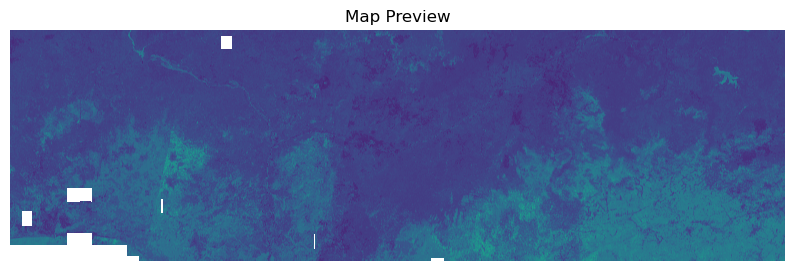

In [31]:
plt.figure(figsize=(10,10))
plt.imshow(data[-60000:-20000])
plt.title("Map Preview")
plt.axis("off")

### Change data type

In [7]:
new_dtype = rasterio.uint8
new_nodata_value = 255 # using -1 causes a bug (negative wrote and read as 0) when compressing the data_prob file later
# https://github.com/rasterio/rasterio/issues/1878
# https://github.com/rasterio/rasterio/issues/2384

In [8]:
# Get nan mask for later
nan_mask = np.isnan(data)

In [9]:
data_binary = (data > 0.5).astype(new_dtype)
data_binary

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 0, 0]], dtype=uint8)

In [10]:
# By changing dtype from float to int, we can reduce the size of the array by x4
print('Data size in GBs:')
print('- float32: ', data.nbytes / 1e9)
print('- uint8: ', data_binary.nbytes / 1e9)

Data size in GBs:
- float32:  58.666748664
- uint8:  14.666687166


In [11]:
data_binary[nan_mask] = new_nodata_value

In [12]:
## nans only work for floats, but we can check that the size of the nan_mask matches
# np.isnan(data_binary).sum()

In [13]:
data_binary

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   1,   0,   1],
       [255, 255, 255, ...,   1,   0,   0]], dtype=uint8)

In [14]:
# unique, counts = np.unique(data_binary, return_counts=True)
# #counts_dict = dict(zip(unique, counts))
# counts[-1] == nan_mask.sum()

### Compress

In [15]:
meta.update({'compress': 'lzw'}) #, 'predictor': 2}) # 'zstd_level': 1
meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': nan,
 'width': 134346,
 'height': 109171,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841193114e-05, 0.0, 2.6916220858073223,
        0.0, -8.983152841193113e-05, 14.047584918475842),
 'compress': 'lzw'}

In [4]:
out_path = preds_dir / f'{base_filename}_binary_uint8_lzw.tif'

In [16]:
# Save as a new tif file
out_path = preds_dir / f'{base_filename}_binary_uint8_lzw.tif'
meta.update({'dtype': new_dtype, 'nodata': new_nodata_value})
with rasterio.open(out_path, 'w', **meta) as dst:
    dst.write(data_binary, 1)

In [5]:
# Open and check size in RAM, plot
with rasterio.open(out_path) as map:
    new_meta = map.meta
    new_data = map.read(1)
new_data

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   1,   0,   1],
       [255, 255, 255, ...,   1,   0,   0]], dtype=uint8)

In [7]:
new_meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 134346,
 'height': 109171,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841193114e-05, 0.0, 2.6916220858073223,
        0.0, -8.983152841193113e-05, 14.047584918475842)}

In [19]:
new_data.nbytes / 1e9

14.666687166

### Same for probability map

In [20]:
data_prob = (data * 100).astype(new_dtype) # convert to 0-100 scale (instead of 0-1), and convert to uint8 (will truncate values)
data_prob

array([[15, 20, 21, ..., 26, 22, 19],
       [15, 27, 22, ..., 13,  9, 22],
       [ 9, 34, 35, ..., 21, 32, 32],
       ...,
       [ 0,  0,  0, ..., 19, 21, 47],
       [ 0,  0,  0, ..., 57, 32, 57],
       [ 0,  0,  0, ..., 61, 37, 42]], dtype=uint8)

In [11]:
# # Get nan mask for later
# nan_mask = np.isnan(data)

In [21]:
data_prob[nan_mask] = new_nodata_value
data_prob

array([[ 15,  20,  21, ...,  26,  22,  19],
       [ 15,  27,  22, ...,  13,   9,  22],
       [  9,  34,  35, ...,  21,  32,  32],
       ...,
       [255, 255, 255, ...,  19,  21,  47],
       [255, 255, 255, ...,  57,  32,  57],
       [255, 255, 255, ...,  61,  37,  42]], dtype=uint8)

In [27]:
# unique, counts = np.unique(data_prob, return_counts=True)
# unique, counts[0] == nan_mask.sum()

In [22]:
new_out_path = Path(str(out_path).replace('binary', 'prob'))
#new_out_path = Path(str(new_out_path).replace('lzw', 'zstd-pred2'))
new_out_path

PosixPath('../data/predictions/nigeria-cropharvest-full-country-2020/combined_prob_uint8_lzw.tif')

In [23]:
meta.update({'dtype': new_dtype, 'nodata': new_nodata_value, 'compress': 'lzw'})#, 'predictor': 2})
meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255,
 'width': 134346,
 'height': 109171,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841193114e-05, 0.0, 2.6916220858073223,
        0.0, -8.983152841193113e-05, 14.047584918475842),
 'compress': 'lzw'}

In [24]:
# Save as a new tif file
with rasterio.open(new_out_path, 'w', **meta) as dst:
    dst.write(data_prob, 1)

In [25]:
# Open and check size in RAM, plot
with rasterio.open(new_out_path) as map:
    new_meta = map.meta
    new_data = map.read(1)
new_data

array([[ 15,  20,  21, ...,  26,  22,  19],
       [ 15,  27,  22, ...,  13,   9,  22],
       [  9,  34,  35, ...,  21,  32,  32],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [26]:
new_data.min()

1

In [27]:
new_data.nbytes

14666687166